# Ensemble Modeling
This notebook demonstrates how **MASSpy** can be used to generate an ensemble of models. 

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

import logging
logging.getLogger("").setLevel("CRITICAL")

# Configure roadrunner to allow for more output rows
import roadrunner
roadrunner.Config.setValue(
    roadrunner.Config.MAX_OUTPUT_ROWS, 1e6)

from mass import MassConfiguration, Simulation
from mass.example_data import create_examples_model

mass_config = MassConfiguration()
mass_config.decimal_precision = 12 # Round 12 places after decimal

# Load the model
reference_model = create_example_model("Glycolysis")

## Generating Data for Ensembles

In addition to loading external sources of data for use (e.g., loading excel sheets), sampling can be used to get valid data for the generation of ensembles. As an example, a small set of samples are generated for use in this notebook.

Utilizing [COBRApy flux sampling](https://cobrapy.readthedocs.io/en/latest/sampling.html#), the following flux samples are used in generating the ensemble of models. All steady state flux values are set to allow to deviation by up to 80% of their defined baseline values.

In [2]:
from cobra.sampling import sample

In [3]:
flux_percent_deviation = 0.8
for reaction in reference_model.reactions:
    flux = reaction.steady_state_flux
    reaction.bounds = sorted([
        round(flux * (1 - flux_percent_deviation),
              mass_config.decimal_precision),
        round(flux * (1 + flux_percent_deviation),
              mass_config.decimal_precision)])
    
flux_samples = sample(reference_model, n=10, seed=25)

Utilizing [MASSpy concentration sampling](./thermo_concentrations.ipynb#Concentration-Sampling), the following concentration samples are used in generating the ensemble of models. All concentration values are set to allow deviation by up to 80% of their defined baseline values.

In [4]:
from mass.thermo import ConcSolver, sample_concentrations

In [5]:
conc_solver = ConcSolver(
    reference_model,
    excluded_metabolites=["h_c", "h2o_c"],
    equilibrium_reactions=["ADK1"],
    constraint_buffer=1e-7)

conc_solver.setup_sampling_problem(
    conc_percent_deviation=0.8,
    Keq_percent_deviation=0)

conc_samples = sample_concentrations(conc_solver, n=10, seed=25)

Because there are 10 flux data sets and 10 concentration data sets being passed to the function, there are $10 * 10 = 100$ models generated in total.

## Creating an Ensemble

In [6]:
from mass.simulation import ensemble, generate_ensemble_of_models

### Generating new models

The `ensemble` submodule has two functions for creating models from `pandas.DataFrame` objects:

* The `create_models_from_flux_data()` function creates an ensemble of models from a `DataFrame` containing flux data, where rows correspond to samples and columns correspond to reaction identifiers.
* The `create_models_from_concentration_data()` function creates an ensemble of models from a `DataFrame` containing concentration data, where rows correspond to samples and columns correspond to metabolite identifiers.

The functions can be used separately or together to generate models. In this example, an ensemble of 100 models is generated by utilizing both mode; generation methods. 

First, the 10 flux samples are used to generate 10 models with varying flux states from a single reference `MassModel`.

In [7]:
flux_models = ensemble.create_models_from_flux_data(
    reference_model, data=flux_samples)
len(flux_models)

10

The `list` of models are passed to the `create_models_from_concentration_data()` function along with the concentration samples to create models with varying concentration states. By treating each of the 10 models with varying flux states as a reference model in addition to providing 10 concentration samples, 100 total models are generated.

In [8]:
conc_models = []
for ref_model in flux_models:
    conc_models += ensemble.create_models_from_concentration_data(
        ref_model, data=conc_samples)
len(conc_models)

100

Generating models does not always ensure that the models are thermodynamically feasible. The `ensure_positive_percs()` function is used to calculate PERCs (pseudo-elementary rate constants) for all reactions provided to the `reactions` argument. Those that produce all positive PERCs are separated from those that produce at least one negative PERC, and two lists that contain the seperated models are returned.

If the `update_values` argument is set to `True`, PERC values are updated for models that produce all positive PERCs.

In [9]:
# Exclude boundary reactions from PERC calculations for the example
reactions_to_check_percs = [
    r.id for r in reference_model.reactions
    if r not in reference_model.boundary]

positive, negative = ensemble.ensure_positive_percs(
    models=conc_models, reactions=reactions_to_check_percs, 
    update_values=True)

print("Models with positive PERCs: {0}".format(len(positive)))
print("Models with negative PERCs: {0}".format(len(negative)))

Models with positive PERCs: 100
Models with negative PERCs: 0


The `ensure_steady_state()` function is used to ensure that models are able to reach a steady state. If `update_values=True`, models that reach a steady state are updated with the new steady state values.

In [10]:
feasible, infeasible = ensemble.ensure_steady_state(
    models=positive, strategy="simulate",
    update_values=True, decimal_precision=True)

print("Reached steady state: {0}".format(len(feasible)))
print("No steady state reached: {0}".format(len(infeasible)))

mass/simulation/simulation.py:828 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


Reached steady state: 90
No steady state reached: 10


The `perturbations` argument of the `ensure_steady_state()` method is used to check that models are able to reach a steady state with a given perturbation. 

In [11]:
feasible, infeasible = ensemble.ensure_steady_state(
    models=feasible, strategy="simulate",
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    update_values=False, decimal_precision=True)

print("Reached steady state: {0}".format(len(feasible)))
print("No steady state reached: {0}".format(len(infeasible)))

mass/simulation/simulation.py:828 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


Reached steady state: 88
No steady state reached: 2


All models returned as "feasible" are considered to be thermodynamically feasible and able to reach a steady state, even with the given disturbance.

## Simulating an Ensemble of Models

Once an ensemble of models is generated, the `Simulation` object can be used to simulate the ensemble of models.

In [12]:
sim = Simulation(reference_model, verbose=True)

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


Three criteria must be met to add additional models to an existing `Simulation` object:

1. The model must have ODEs equivalent to those of the `Simulation.reference_model`.
2. All models must have unique identifiers.
3. Numerical values that are necessary for simulation must already be defined for a model.

If the criteria are met, additional models can be loaded into the `Simulation` using the `add_models()` method.

In [13]:
sim.add_models(models=feasible)
print("Number of models added: {0}".format(len(feasible)))
print("Number of models total: {0}".format(len(sim.models)))

Number of models added: 88
Number of models total: 89


The `simulate()` method is used to simulate multiple models. By default, all loaded models are simulated, including the `reference_model`.

In [14]:
conc_sol_list, flux_sol_list = sim.simulate(time=(0, 1000))
print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

ConcSols returned: 89
FluxSols returned: 89


To simulate a subset of the models, a list of models or their identifiers can be provided to the `simulate()` method. For example, to simulate the subset of models with identical concentration states but different flux states:

In [15]:
model_subset = [model for model in sim.models if model.endswith("_C0")]
conc_sol_list, flux_sol_list = sim.simulate(
    models=model_subset, time=(0, 1000))
print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

ConcSols returned: 7
FluxSols returned: 7


Similar to the `simulate()` method, the `find_steady_state()` method can be used to determine a steady state for each model in an ensemble or subset of models.

In [16]:
conc_sol_list, flux_sol_list = sim.find_steady_state(
    models=model_subset, strategy="simulate")
print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

ConcSols returned: 7
FluxSols returned: 7


If an exception occurs for a model during steady state determination or simulation (e.g., no steady state exists), the MassSolution objects that correspond to the failed model will return empty.

In [17]:
# Create a simulation with the reference model and an infeasible one 
infeasible_sim = Simulation(reference_model)
infeasible_sim.add_models(infeasible[0])

conc_sol_list, flux_sol_list = infeasible_sim.find_steady_state(
    strategy="simulate", perturbations={"kf_ATPM": "kf_ATPM * 1.5"})

print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

for model, sol in zip(sim.models, conc_sol_list):
    print("Solutions for {0}: {1}".format(str(model), bool(sol)))

ConcSols returned: 2
FluxSols returned: 2
Solutions for Glycolysis: True
Solutions for Glycolysis_F0_C0: False


mass/simulation/simulation.py:828 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


### Visualizing Ensemble Results

Through visualization features of **MASSPy**, the results of simulating the ensemble can be visualized using the `plot_ensemble_time_profile()` and `plot_ensemble_phase_portrait()` functions.

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)

A list of `MassSolution` objects is required to use an ensemble visualization function. The output of `simulate()` method for an ensemble of models can be placed into the functions directly.

In [19]:
sim = Simulation(reference_model, verbose=True)
sim.add_models(models=feasible)

conc_sol_list, flux_sol_list = sim.simulate(
    models=feasible, time=(0, 1000),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    decimal_precision=True)

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


The `plot_ensemble_time_profile()` function works in a manner similar to the `plot_time_profile()` function described in [Time Profiles](./plot_visualization.ipynb#Time-Profiles). The minimal input required is a list of `MassSolution` objects and an iterable that contains strings or objects with identifiers that correspond to keys of the `MassSolution`. The plotted solution lines represent the average (mean) solution.

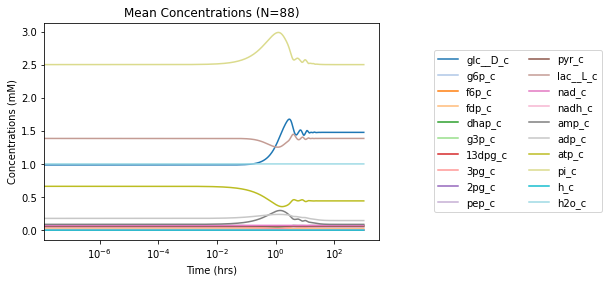

In [20]:
plot_ensemble_time_profile(
    conc_sol_list, observable=reference_model.metabolites,
    interval_type=None,
    legend="right outside", plot_function="semilogx",
    xlabel="Time (hrs)", ylabel="Concentrations (mM)",
    title="Mean Concentrations (N={0})".format(len(conc_sol_list)))

Because the plotted lines are the mean solution values over time for the ensemble, there is some uncertainty associated with the solutions. The `interval_type` argument can be specified to plot the results with a confidence interval. For example, to plot the mean PYK flux with a 95% confidence interval:

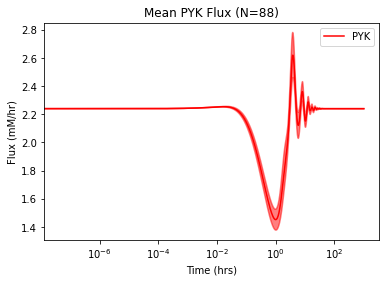

In [21]:
plot_ensemble_time_profile(
    flux_sol_list, observable=["PYK"], legend="best", 
    interval_type="CI=95", # Shading for 95% confidence
    plot_function="semilogx", xlabel="Time (hrs)",
    ylabel="Flux (mM/hr)",
    title="Mean PYK Flux (N={0})".format(len(flux_sol_list)),
    color="red", mean_line_alpha=1,  # Default opacity of mean line
    interval_fill_alpha=0.5,   # Default opacity for interval shading
    interval_border_alpha=0.5)  # Default opacity of border lines


Setting  `interval_type="range"` causes shading between the minimum and maximum solution values. The `mean_line_alpha`, `interval_fill_alpha`, and `interval_border_alpha` kwargs are used to control the opacity of the mean solution, interval borders, and interval shading, respectively.

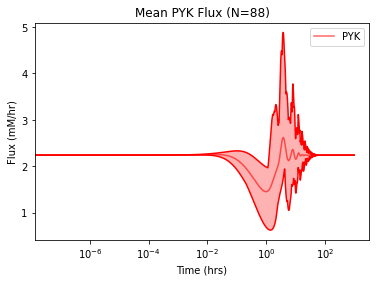

In [22]:
plot_ensemble_time_profile(
    flux_sol_list, observable=["PYK"],
    interval_type="range", # Shading from min to max value
    legend="best", plot_function="semilogx",
    xlabel="Time (hrs)", ylabel="Flux (mM/hr)",
    title="Mean PYK Flux (N={0})".format(len(flux_sol_list)),
    color="red", mean_line_alpha=0.6,  # For opacity of mean line
    interval_fill_alpha=0.3, # For lighter interval shading
    interval_border_alpha=1  # For darker border lines
)

Relative deviations are plotted using the `deviation` kwarg. The `deviation_zero_centered` kwarg is used to shift the results to deviate from 0., and the `deviation_normalization` kwarg is used to normalize each solution.

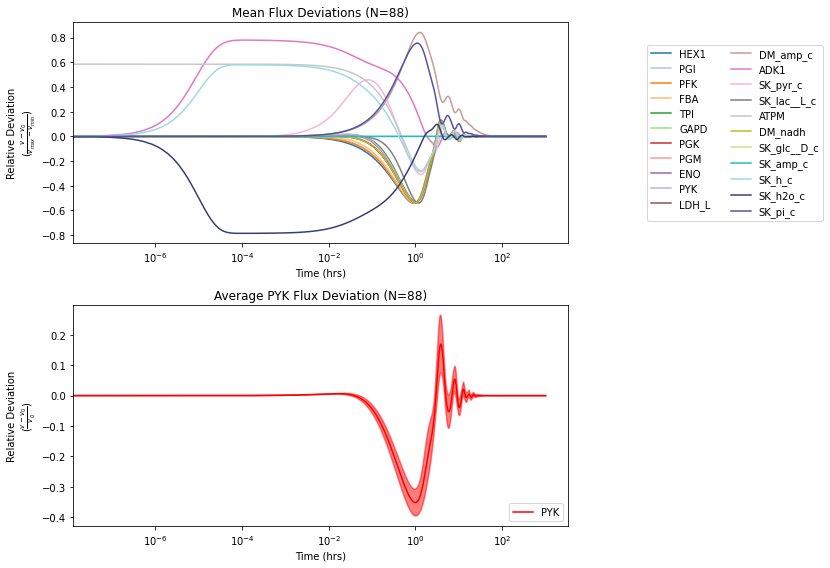

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot all relative flux deviations
plot_ensemble_time_profile(
    flux_sol_list, observable=reference_model.reactions,
    interval_type=None, ax=ax1, legend="right outside",
    plot_function="semilogx", xlabel="Time (hrs)",
    ylabel=("Relative Deviation\n" +\
            r"($\frac{v - v_{0}}{v_{max} - v_{min}}$)"),
    title="Mean Flux Deviations (N={0})".format(len(flux_sol_list)),
    deviation=True,
    deviation_zero_centered=True,  # Center around 0
    deviation_normalization="range")  # Normalized by value range

# Plot PYK relative flux deviations
plot_ensemble_time_profile(
    flux_sol_list, observable=["PYK"],
    interval_type="CI=99",  # 99% confidence interval
    ax=ax2, legend="lower right",
    plot_function="semilogx", xlabel="Time (hrs)",
    ylabel=("Relative Deviation\n" +\
            r"($\frac{v - v_{0}}{v_{0}}$)"),
    title="Average PYK Flux Deviation (N={0})".format(
        len(flux_sol_list)),
    color="red", deviation=True,
    deviation_zero_centered=True,  # Center around 0
    deviation_normalization="initial value")  # Normalized by init. value

fig.tight_layout()

The `plot_ensemble_phase_portrait()` function works in a manner similar to the `plot_phase_portrait()` function described in [Phase Portraits](./plot_visualization.ipynb#Phase-Portraits). The `plot_ensemble_phase_portrait()` function plots the mean solutions for the two ensemble simulation results against each other.

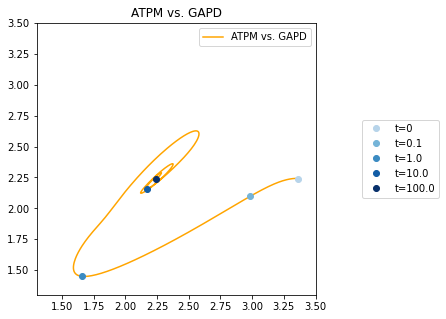

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Createt time points and colors for the time points
time_points = [0, 1e-1, 1e0, 1e1, 1e2]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Blues(np.linspace(0.3, 1, len(time_points)))]

# Plot the phase portrait
plot_ensemble_phase_portrait(
    flux_sol_list, x="ATPM", y="GAPD", ax=ax, legend="upper right",
    xlim=(1.3, 3.5), ylim=(1.3, 3.5),
    title="ATPM vs. GAPD",
    color="orange", linestyle="-",
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside");

## Fast Ensemble Creation

Another function utilized for ensemble creation is the `generate_ensemble_of_models()` function. The `generate_ensemble_of_models()` function is a way to streamline the generation of models for an ensemble with increased performance gains at the cost of user control and increased overhead for setup. Consequently, the `generate_ensemble_of_models()` function may be a more desirable function to use when generating a large number of models. 

The `generate_ensemble_of_models()` function requires a single `MassModel` as a reference model, and sample data as a `pandas.DataFrame` for the `flux_data` and `conc_data` arguments.

* For `flux_data` columns are reaction identifiers, and rows are samples of steady state fluxes.
* For `conc_data` columns are metabolite identifiers, and rows are samples of concentrations (initial conditions).

At least one of the above arguments must be provided for the function to work. After generating the models, a list that contains the model objects is returned.

In [25]:
# Generate the ensemble
models = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples)

Total models generated: 100


To ensure that the PERCs for certain reactions are positive, a `list` of reactions to check can be provided to the `ensure_positive_percs` argument. 

In [26]:
# Exclude boundary reactions from PERC calculations for the example
reactions_to_check_percs = [
    r.id for r in reference_model.reactions
    if r not in reference_model.boundary]

# Generate the ensemble
ensemble = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples,
    ensure_positive_percs=reactions_to_check_percs)

Total models generated: 100
Feasible: 100
Infeasible, negative PERCs: 0


To ensure that all models can reach a steady state with their new values, a strategy for finding the steady state can be provided to the `strategy` argument. 

In [27]:
# Generate the ensemble
models = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples,
    ensure_positive_percs=reactions_to_check_percs,
    strategy="simulate",
    decimal_precision=True)

mass/simulation/simulation.py:828 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


Total models generated: 100
Feasible: 90
Infeasible, negative PERCs: 0
Infeasible, no steady state found: 10


To ensure that all models can reach a steady state with their new values after a given perturbation, in addition to passing a value to the `strategy` argument, one or more perturbations can be given to the `perturbations` argument. The `perturbations` argument takes a `list` of dictionaries, each containing perturbations formatted as described in [Dynamic Simulation](./dynamic_simulation.ipynb#Perturbing-a-Model).

If it is desirable to return the models that were not deemed 'feasible', the `return_infeasible` kwarg can be set to `True` to return a second list that contains only models deemed 'infeasible'.

In [28]:
feasible, infeasible = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples,
    ensure_positive_percs=reactions_to_check_percs,
    strategy="simulate",
    perturbations=[
        {"kf_ATPM": "kf_ATPM * 1.5"},
        {"kf_ATPM": "kf_ATPM * 0.85"}],
    return_infeasible=True,
    decimal_precision=True)

mass/simulation/simulation.py:828 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.
mass/simulation/simulation.py:828 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


Total models generated: 100
Feasible: 88
Infeasible, negative PERCs: 0
Infeasible, no steady state found: 10
Infeasible, no steady state with pertubration 1: 2
Infeasible, no steady state with pertubration 2: 0


Note that perturbations are not applied all at once; each `dict` provided corresponds to a new attempt to find a steady state. For example, two dictionaries passed to the `perturbations` argument indicate that three steady state determinations are performed, once for the model without any perturbations and once for each `dict` provided.

Generally it is recommended to utilize the functions in the `ensemble` submodule to generate small ensembles while experimenting with various settings, and then to utilize the `generate_ensemble_of_models` function to generate the larger ensemble.